# Two Sigma Connect: Rental Listing Inquiries (kaggle)
[How much interest will a new rental listing on RentHop receive?][1]

[1]:https://www.kaggle.com/c/two-sigma-connect-rental-listing-inquiries

#### TODO LIST
1. Spot-check algorithms
    - binarize target variable
    - MinMaxScaler for 'bathrooms', 'bedrooms', 'price'
2. Explore
    - 
 
3. Advanced feature engineering options
    - Description
        - binarize features, i.e. BOW
        - LDA with description
    - 


##### Setup (imports, constants, etc.)

In [1]:
from copy import deepcopy
import pdb
import warnings
from imp import reload
import time
from pprint import pprint
import random

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import (StratifiedShuffleSplit, train_test_split,
                                     validation_curve)
from grid_explore import GridSearchExplorer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, log_loss, make_scorer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import (LabelBinarizer, LabelEncoder,
                                   MinMaxScaler, StandardScaler, OneHotEncoder)
from sklearn.ensemble import (GradientBoostingClassifier,
                              RandomForestClassifier)
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from scipy import stats
from IPython.display import display
from sklearn_pandas import DataFrameMapper

import pdir

from plot_learning_curve import plot_learning_curve

%matplotlib inline

%load_ext autoreload
%autoreload 2

pd.set_option('display.float_format', lambda x: '%.5f' % x)

SEED = 42
np.random.seed(SEED)

DAT_DIR = '../Data/'
SUBM_DIR = '../Submissions/'
TEST_DIR = '../Tests/'
TRAIN_FP = ''.join([DAT_DIR, 'train.json'])
TEST_FP = ''.join([DAT_DIR, 'test.json'])
SAMPLE_FP = ''.join([DAT_DIR, 'sample_submission.csv'])

scorer_acc = make_scorer(accuracy_score)

# using built-in 'neg_log_loss' scoring param used for simplicity
# source code show exact same make_scorer call, kept for reference
scorer = make_scorer(log_loss, greater_is_better=False,
                     needs_proba=True)

scoring = 'neg_log_loss'


/Users/mdlynch37/anaconda3/envs/rental-interest/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


##### Utility functions

In [2]:
def save_submission(preds, fp):
    """Ensures correct format and class ordering."""
    submit = (pd.DataFrame(preds,
                           columns=['high', 'low', 'medium'],
                           index=X_sub.index)
              .loc[:, ['high', 'medium', 'low']])
    
    # ensure label ordering correct
    assert submit.high.sum() < submit.medium.sum() < submit.low.sum(), (
        'Interest level probpip abilities are mismatched')
    
    submit.to_csv(fp)
    
    return submit

In [3]:
def plot_validation_curve(estimator, X, y, param_name, param_range,
                          cv=10, scoring='accuracy', n_jobs=1):
    """Plots vaildation curve for given hyperparamters.
    
    Parameters
    ----------
    estimator : sklearn Classifier
    param_name :  str
    param_range : iterable
    kwargs : passed to matplotlib plot
    
    Returns
    -------
    plt : matplotlib plot
    """
    
    train_scores, valid_scores = validation_curve(
        estimator, X, y, param_name=param_name, param_range=param_range,
        cv=cv, scoring=scoring, n_jobs=n_jobs) 
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    valid_scores_mean = np.mean(valid_scores, axis=1)
    valid_scores_std = np.std(valid_scores, axis=1)
    
    
    plt.title('Validation Curve with {}'.format(type(estimator).__name__))
    plt.xlabel(param_name)
    plt.ylabel('Score')
    
    lw = 2
    
    plt.plot(param_range, train_scores_mean, label='Training score',
             color='darkorange', lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color='darkorange', lw=lw)
    
    plt.plot(param_range, valid_scores_mean, label='Cross-validation score',
             color='navy', lw=lw)
    plt.fill_between(param_range, valid_scores_mean - valid_scores_std,
                     valid_scores_mean + valid_scores_std, alpha=0.2,
                     color='navy', lw=lw)

    plt.legend(loc='best')
    plt.show()
    
    return plt.gca()

In [4]:
from pandas.util.testing import assert_series_equal

def exp_int(col, prior):
    """Expected interest level with Bayesian prior."""
    return (col.sum()+prior)/(len(col)+1)

class TestRentalInterest:
    
    def test_bayes_prior_exp_interest(self):
        man_ids = ['a', 'a', 'a', 'b', 'b', 'c']
        int_lev = [1, 2, 3, 2, 3, 1]

        df = pd.DataFrame(dict(manager_id=man_ids, interest_level=int_lev))

        prior = 1.2
        exp_int1 = df.groupby('manager_id')['interest_level'].apply(exp_int, prior)
        
        exp_a = (prior + 1 + 2 + 3)/4
        exp_b = (prior + 2 + 3)/3
        exp_c = (prior + 1)/2
        
        exp_int2 = pd.Series(dict(a=exp_a, b=exp_b, c=exp_c))
        
        assert_series_equal(exp_int1, exp_int2, check_names=False)


TestRentalInterest().test_bayes_prior_exp_interest()


In [5]:
def best_grid_results(grid):
    results = []
    results.append('Best score: {:.5f}\n'.format(grid.best_score_))
    results.append('*** For parameters: ***')
    for param, val in grid.best_params_.items():
        results.append('{}: {}'.format(param, val))
    return '\n'.join(results)

##### Outlier removal functions

In [6]:
from preprocessing import *
from eda_plots import *

## Metric

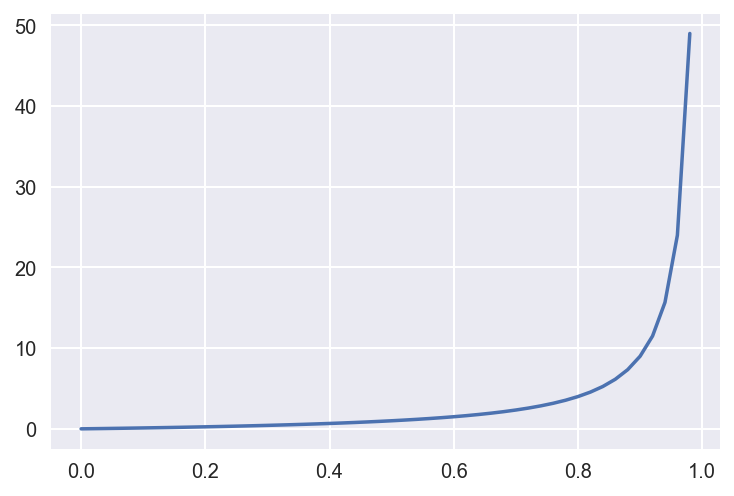

In [7]:
f = lambda x: x/(1-x)
y = np.linspace(0, 1, endpoint=False)
plt.plot(y, f(y))

# Exploratory Data Analysis

In [7]:
df = read_rental_interest(TRAIN_FP)

## Price

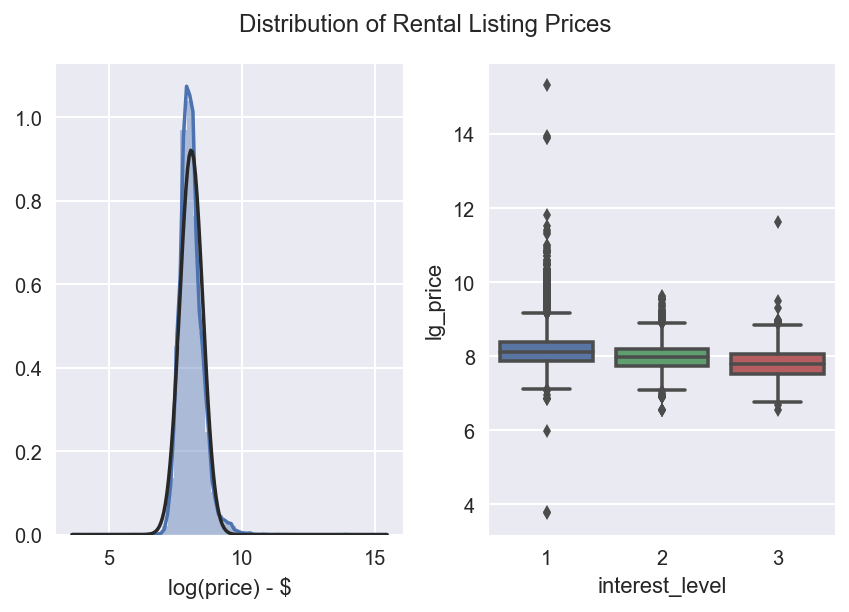

In [26]:
data = df.assign(lg_price=np.log(df.price))

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(6, 4))
sns.distplot(data.lg_price, fit=stats.norm, ax=ax1)
ax1.set_xlabel('log(price) - $')

sns.boxplot(y='lg_price', x='interest_level', data=data, ax=ax2)
plt.suptitle('Distribution of Rental Listing Prices', y=1.05)

plt.tight_layout()

__Missing__

In [15]:
df.price.sort_values().head(10)

listing_id
7060255     43
6813772     45
6871682    401
6865783    695
6852585    695
6831246    695
6859573    695
7127753    700
6934177    800
6952911    868
Name: price, dtype: int64

Can consider 43 and 45 vals as missing values

__Outliers__

In [16]:
price_outls = df[is_price_outl(df.price, k=3.5)].price
print('{} outliers found with Tukey test with k=3.5'.format(len(price_outls)))
display(price_outls.sort_values().head())

95 outliers found with Tukey test with k=3.5


listing_id
7060255       43
6813772       45
6871682      401
7083974    24000
6857092    24000
Name: price, dtype: int64

__Relevance__

lg_price chi2 p-val = 0.0000 (rounded)


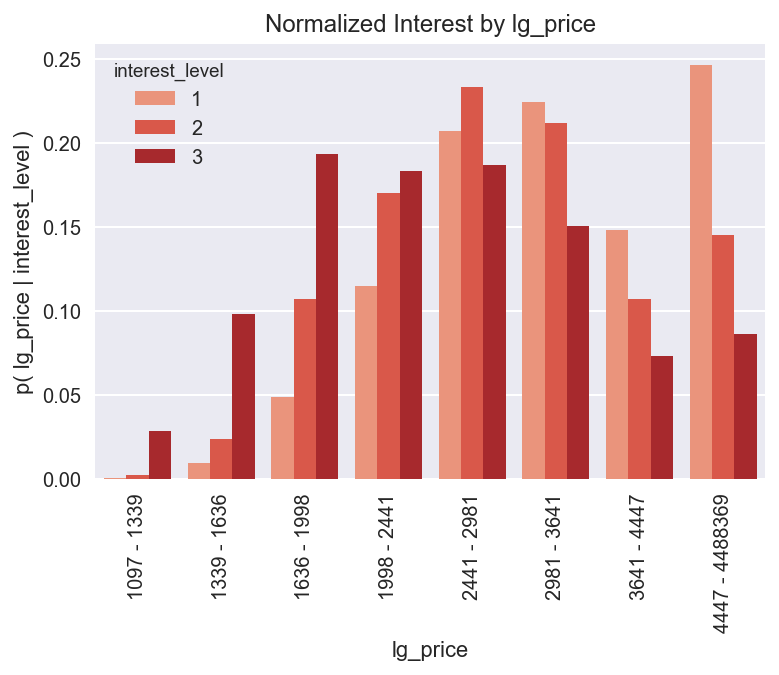

In [28]:
data = df.assign(lg_price=np.log(df.price))

bins = [7, 7.2, 7.4, 7.6, 7.8, 8, 8.2, 8.4, data.lg_price.max()]
plot_prob_x_for_hue(x='lg_price', data=data, hue='interest_level',
                    bins=bins, exp_xlabels=True)
plt.show()

### Bedrooms and Bathrooms

Dropped 95 price outliers (0.19%) with Tukey test constant 3.5


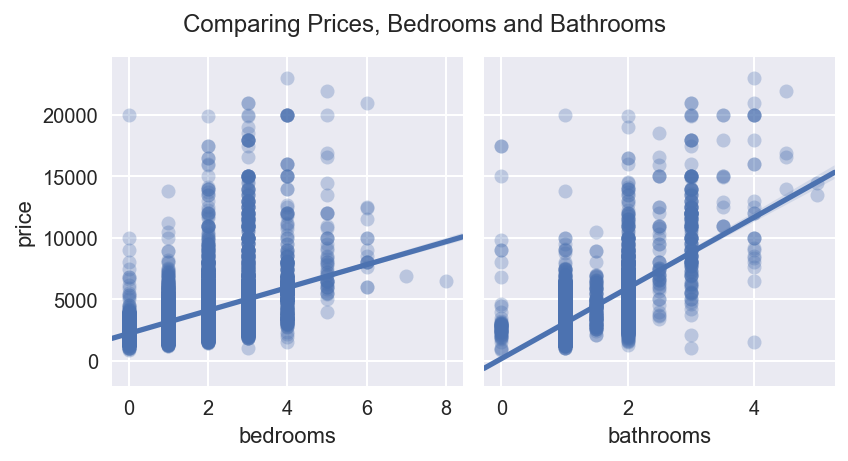

In [14]:
data = df[['bedrooms', 'bathrooms', 'price']]
data = drop_price_outl(data, k=3.5)  # for plotting
data = data.sample(frac=.2, random_state=SEED)  # for performance

sns.pairplot(
    data=data,
    x_vars=['bedrooms', 'bathrooms'],
    y_vars=['price'],
    kind='reg',
    size=3,
    plot_kws=dict(scatter_kws=dict(alpha=.3))
)
plt.suptitle('Comparing Prices, Bedrooms and Bathrooms', y=1.05)
plt.tight_layout()

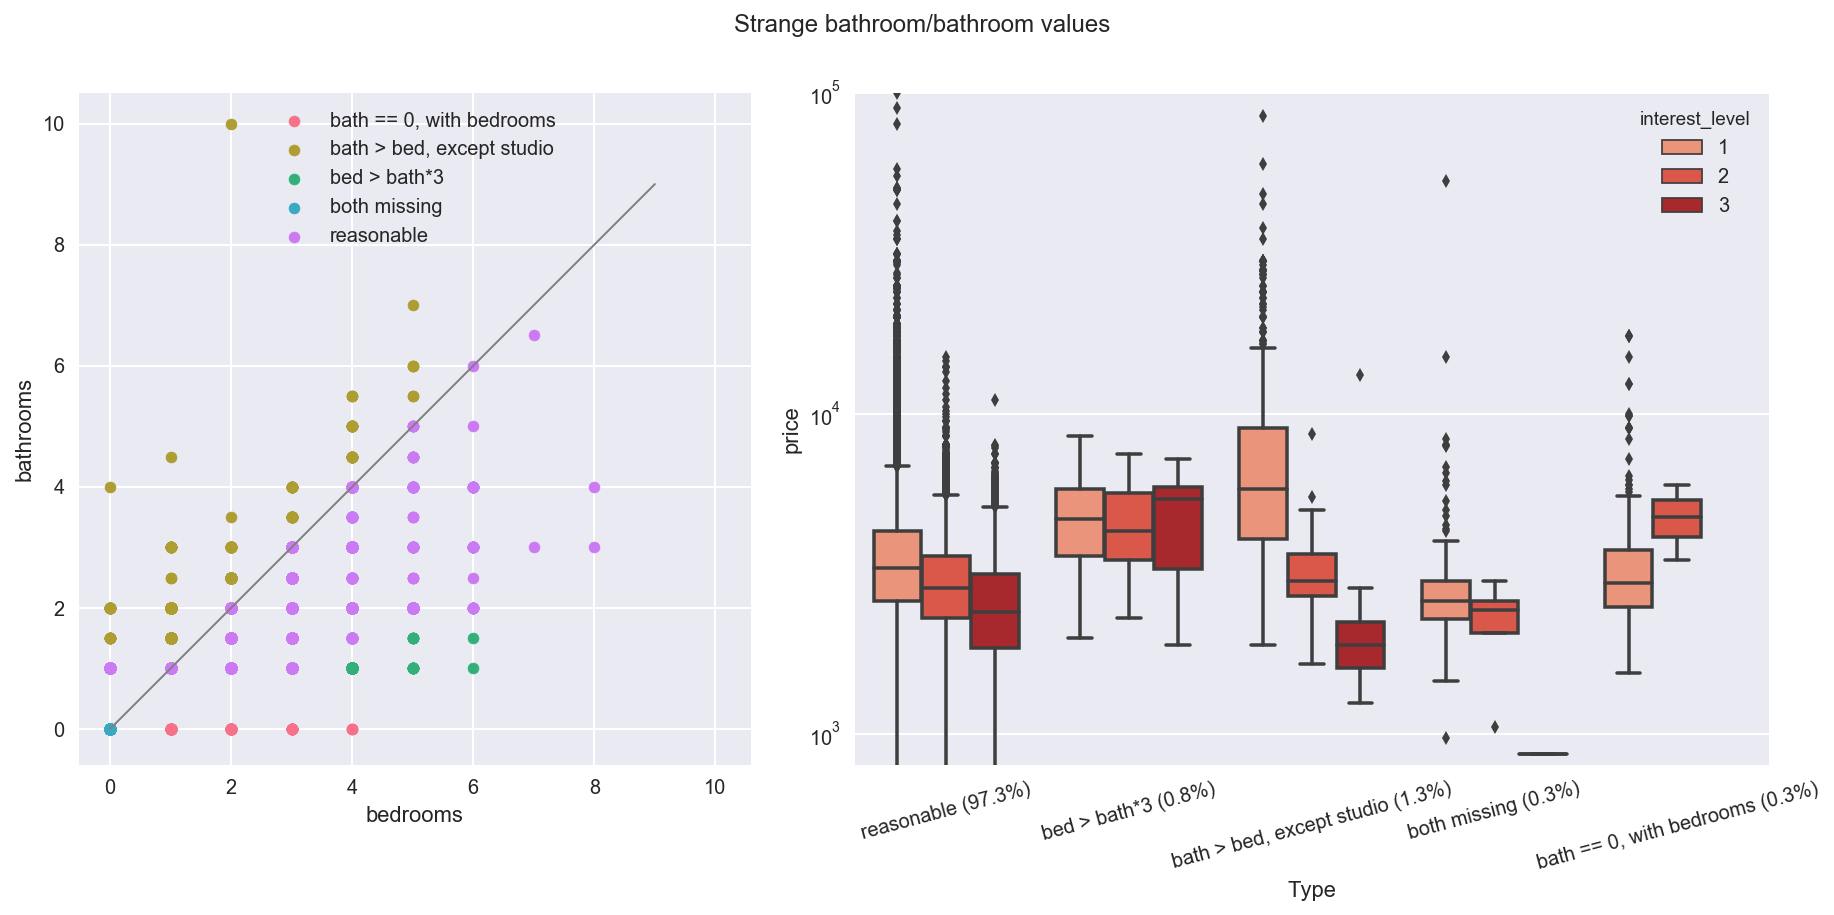

In [24]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(13, 6),
                               gridspec_kw = dict(width_ratios=[3, 4]))

data = set_bedbath_types(df)

grouped = data.groupby('Type')
hue_colors = sns.color_palette('husl', 5).as_hex()
for color, (key, group) in zip(hue_colors, grouped):
    group.plot(kind='scatter', x='bedrooms', y='bathrooms', label=key,
               ax=ax1, color=color, s=30)
ax1.plot([0,9], [0,9], 'gray', linewidth=1)
ax1.axis('square')


with sns.color_palette(palette=sns.color_palette('Reds', 4)[1:]):
    sns.boxplot(y='price', x='Type', data=data,
                hue='interest_level', ax=ax2)
xticklabels = []
cnts = data.Type.value_counts(normalize=True)
for t in ax2.get_xticklabels():
    lbl = t.get_text()
    s = '{} ({:.1%})'.format(lbl, cnts[lbl])
    xticklabels.append(s)

ax2.set_xticklabels(xticklabels, rotation=15)
ax2.set_yscale('log')
ax2.set_ylim(800, 1e5)

plt.suptitle('Strange bathroom/bathroom values', y=1.05)
plt.tight_layout()

- Shows something fishy going on with bathrooms for 1.6% of the data

### Geo-coordinates

Dropped 68 geo-coordinate outliers (0.14%)


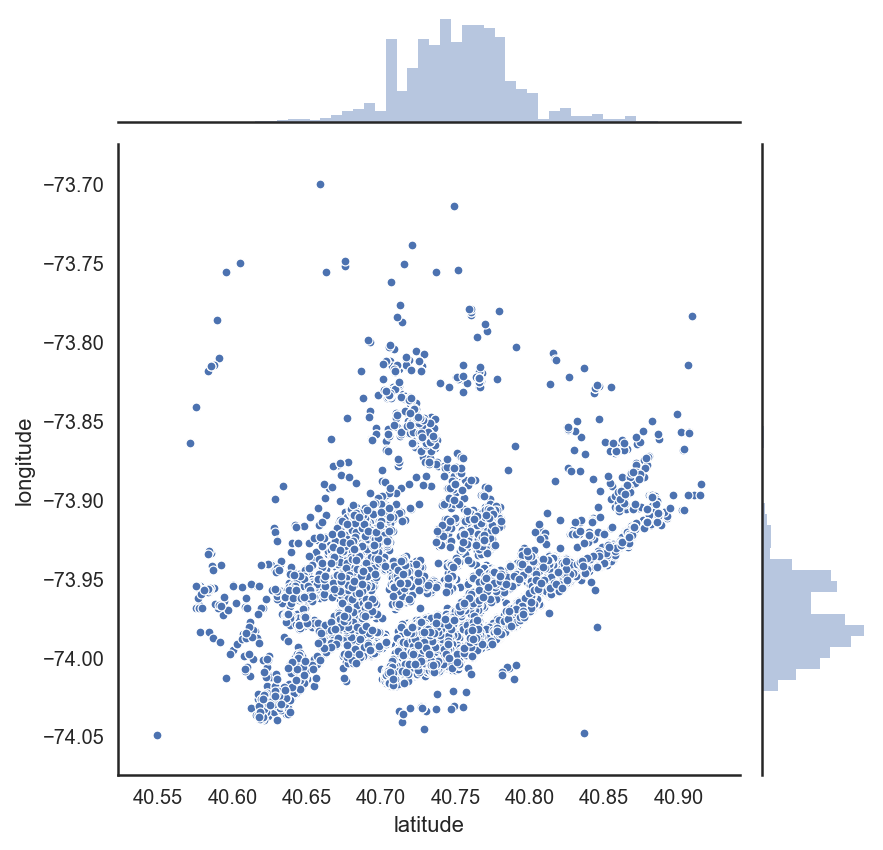

In [17]:
data = drop_geo_outl(df)
with sns.axes_style('white'):
    sns.jointplot('latitude', 'longitude', data=data, stat_func=None,
                  joint_kws=dict(edgecolor='w', lw=.6, s=20)
)
plt.show()

In [11]:
np.exp(-.70)

0.49658530379140953

### Dates

day_name chi2 p-val = 0.0000 (rounded)
month chi2 p-val = 0.3784 (rounded)


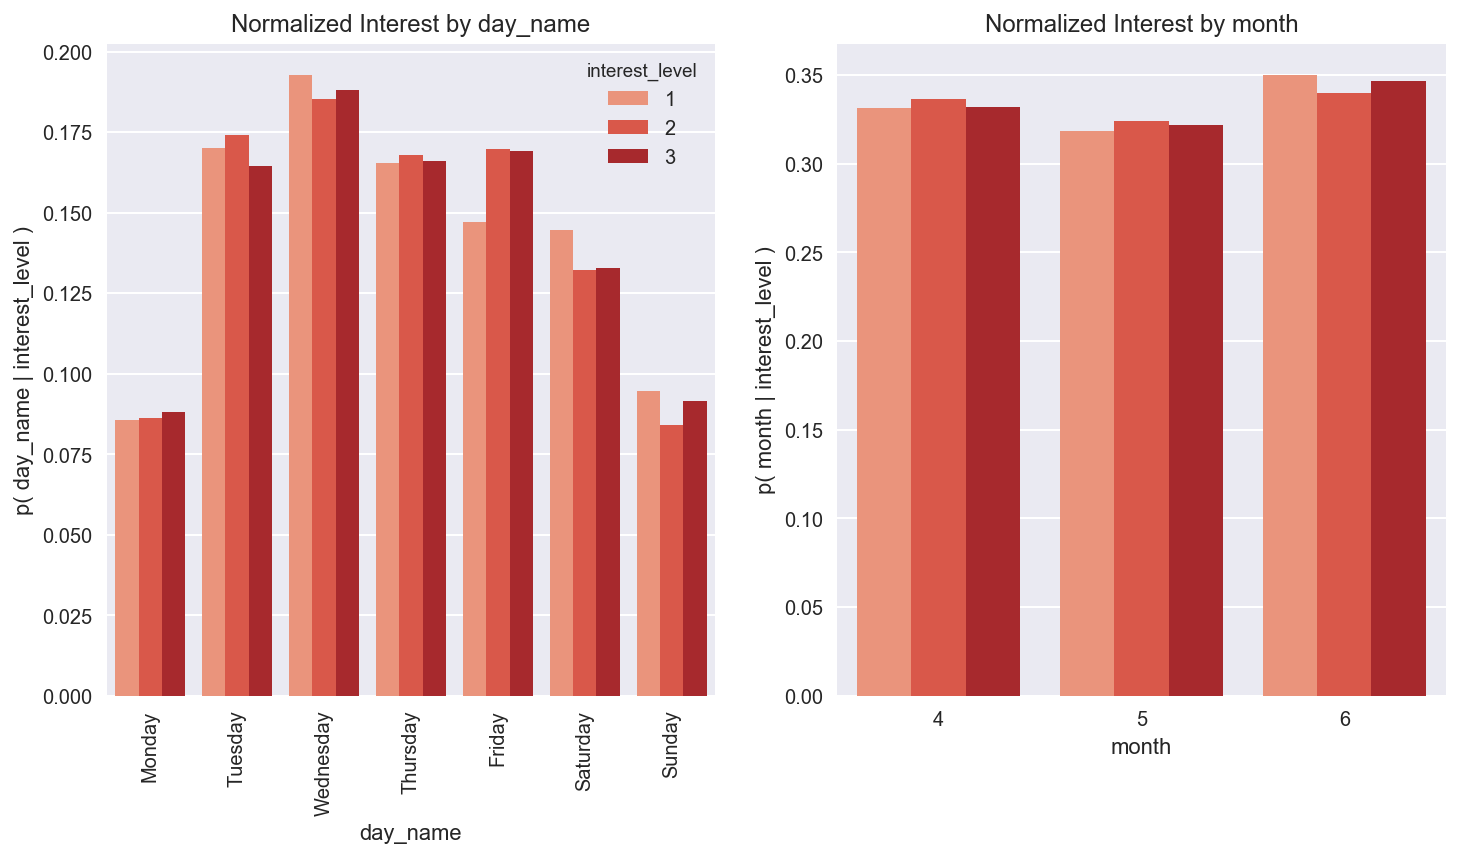

In [29]:
df['month']    = df.created.map(lambda x: x.month).astype(int)
df['day']      = df.created.map(lambda x: x.day).astype(int)
df['day_name'] = df.created.dt.weekday_name

day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday',
             'Friday', 'Saturday', 'Sunday']

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))
plot_prob_x_for_hue(x='day_name', data=df, hue='interest_level',
                    bins=None, order=day_order, ax=ax1)
plot_prob_x_for_hue(x='month', data=df, hue='interest_level',
                    bins=None, ax=ax2)
ax2.legend('')
plt.show()

### Addresses

In [512]:
df = read_rental_interest(TRAIN_FP)

Dropped 68 geo-coordinate outliers (0.14%)


How many missing display addresses have street addresses?

In [539]:
df[(df.street_address!='') & (df.display_address=='')].shape

(126, 14)

How many missing display addresses?

In [540]:
df[df.display_address==''].shape

(135, 14)

In [521]:
print('{} unique display addresses'.format(len(df.display_address.unique())))

8826 unique display addresses


In [522]:
df.display_address.value_counts().head()

Broadway            438
East 34th Street    355
Second Avenue       349
Wall Street         332
West 37th Street    287
Name: display_address, dtype: int64

How many listings have the same display address but different coordinates?

In [34]:
addr_cnts = df.groupby('display_address').apply(
    lambda x: len(x.latitude.unique()))

print((addr_cnts>1).sum())
display(addr_cnts.sort_values(ascending=False).head())

1951


display_address
                    117
Broadway             67
Second Avenue        63
First Avenue         56
Lexington Avenue     40
dtype: int64

### Number of photos

In [38]:
data = pd.concat([xxx,df.interest_level.to_frame().reset_index()], axis=1)
data['price'] = np.exp(data.lg_price).values
data.head()

,lg_price,lg_n_posts,n_photos,listing_id,interest_level,price
0,8.00637,4.49981,5.00000,7211212,2,3000.00000
1,7.71869,4.49981,5.00000,7150865,1,2250.00000
2,7.69621,4.49981,5.00000,6887163,3,2200.00000
3,7.57558,4.49981,4.00000,6888711,1,1950.00000
4,7.60090,4.49981,4.00000,6934781,1,2000.00000


In [31]:
(df.loc[:, 
       ['price', 'photos', 'interest_level']]
    .head()
)

,price,photos,interest_level
listing_id,,,
7211212,3000,[https://photos.renthop.com/2/7211212_1ed4542e...,2
7150865,5465,[https://photos.renthop.com/2/7150865_be3306c5...,1
6887163,2850,[https://photos.renthop.com/2/6887163_de85c427...,3
6888711,3275,[https://photos.renthop.com/2/6888711_6e660cee...,1
6934781,3350,[https://photos.renthop.com/2/6934781_1fa4b41a...,1


n_photos chi2 p-val = 0.0000 (rounded)


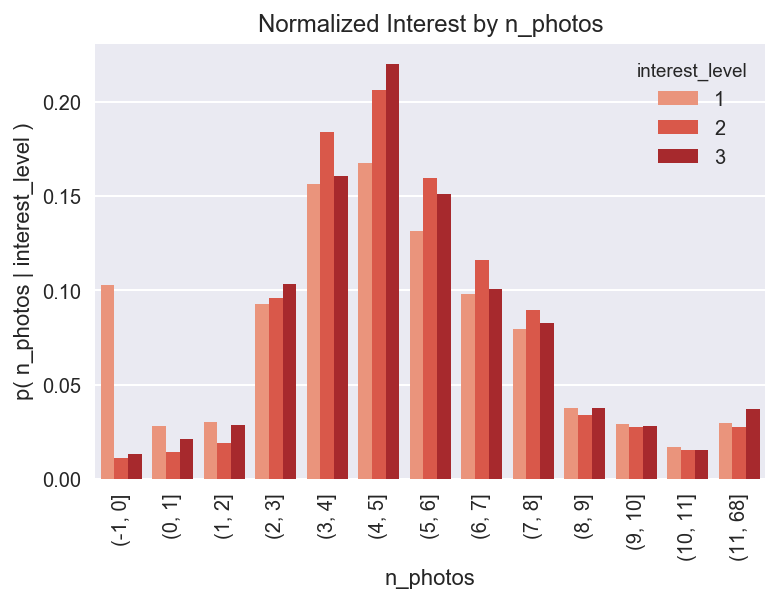

In [55]:
# do number of photos affect interest?
x = 'n_photos'
hue = 'interest_level'
data = df.assign(n_photos=df.photos.map(lambda x: len(x)))

bins = [-1] + list(range(12)) + [data[x].max()]
plot_prob_x_for_hue(x, data.query('n_photos < 15'), hue, bins=bins)
plt.show()

### Number of Features

n_feats chi2 p-val = 0.0000 (rounded)


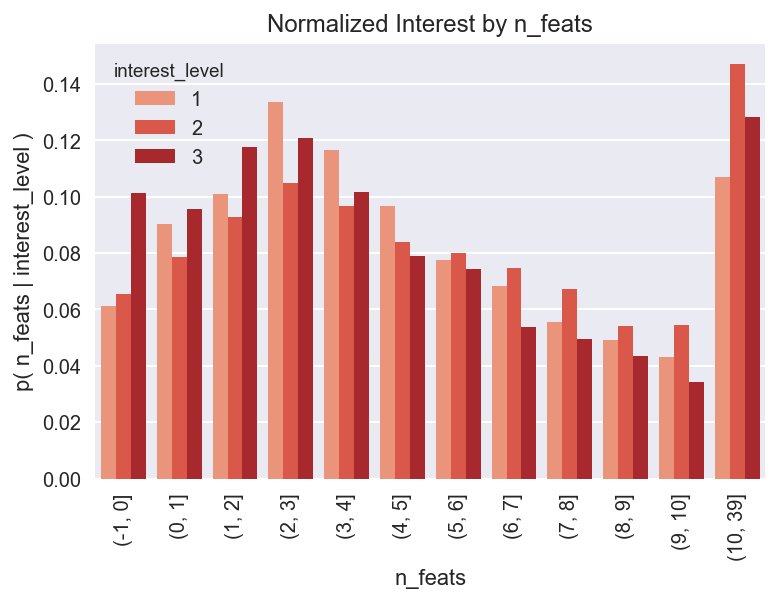

In [31]:
# do number of features affect interest?
data = df.assign(n_feats=df.features.apply(lambda x: len(x)))

x = 'n_feats'
hue = 'interest_level'
bins = [-1] + list(range(11)) + [data[x].max()]
plot_prob_x_for_hue(x, data.query('n_feats < 19'), hue, bins)
plt.show()

### Length of Description

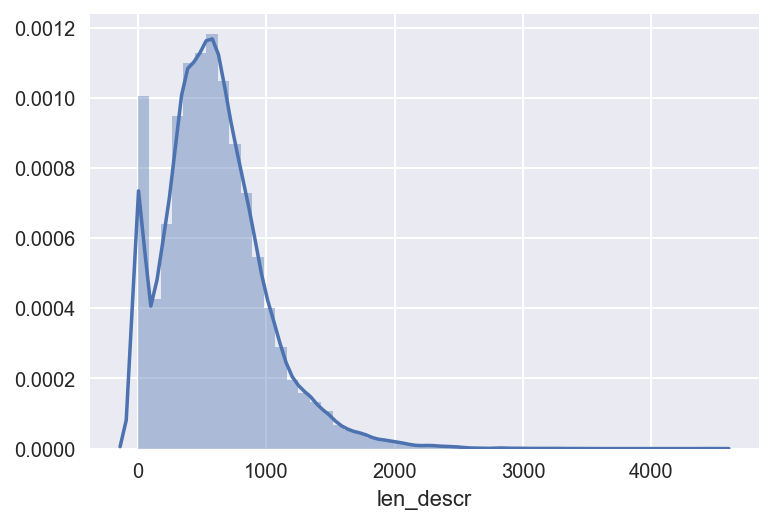

In [32]:
data = df.assign(len_descr=df.description.apply(lambda x: len(x)))
sns.distplot(data.len_descr)
plt.show()

In [33]:
df.description = df.description.str.strip()

len_descr chi2 p-val = 0.0000 (rounded)


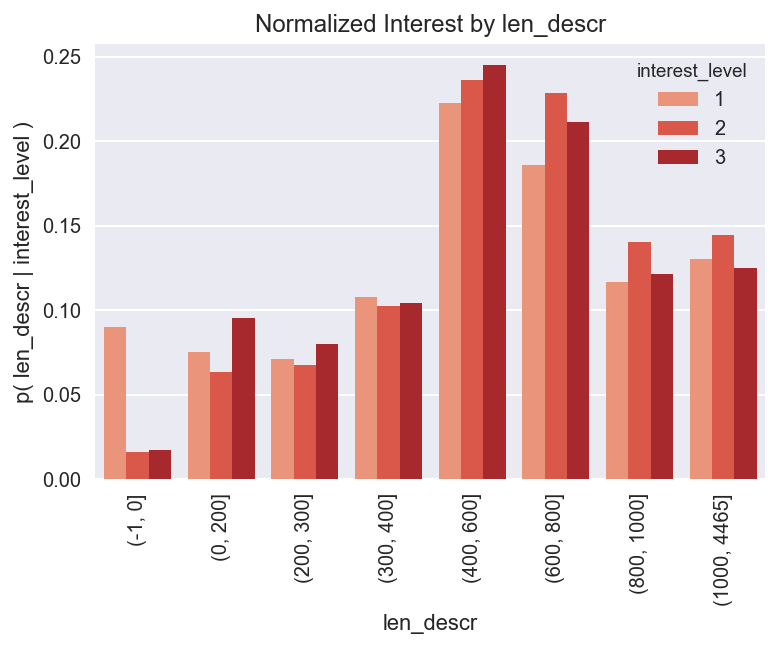

In [39]:
# does length of description affect interest?
data = df.assign(len_descr=df.description.apply(lambda x: len(x)))
x = 'len_descr'
hue = 'interest_level'

bins = [-1, 0, 200, 300, 400, 600, 800, 1000, data.len_descr.max()]
plot_prob_x_for_hue(x=x, data=data, hue=hue, bins=bins)
plt.show()

In [194]:
data.len_descr.value_counts(ascending=False).head()

0      3333
23      344
105     135
497      90
318      89
Name: len_descr, dtype: int64

In [190]:
data[data.len_descr==8].description.iat[0]

'        '

### Manager Activity and Performance

- Total posts
- Posts/duration
- Rating/post

In [12]:
read_rental_interest(TEST_FP).shape

(74659, 13)

In [13]:
df.shape

(49352, 14)

In [46]:
df = read_rental_interest(TRAIN_FP)

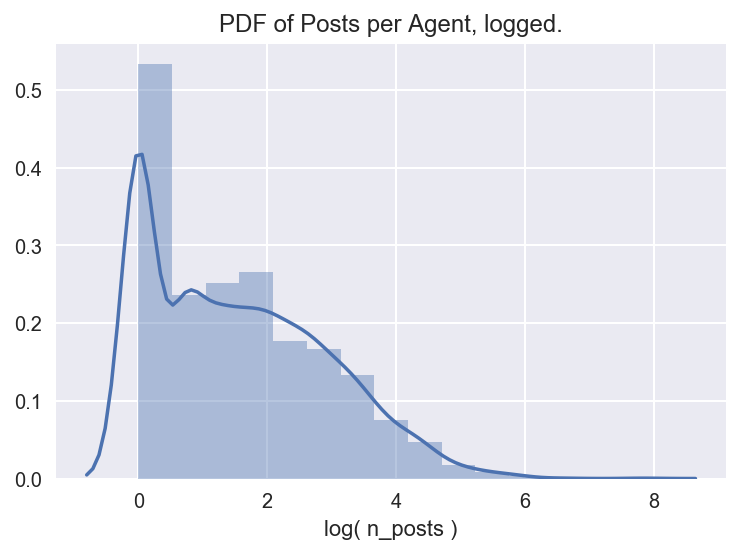

In [47]:
n_posts = df.manager_id.value_counts().rename('n_posts')

sns.distplot(np.log(n_posts), bins=15)
plt.xlabel('log( n_posts )')
plt.title('PDF of Posts per Agent, logged.')

In [55]:
# see if activity of agents affects interest

prior = df.interest_level.mean()
avg_int = (df.groupby('manager_id')['interest_level']
           .apply(exp_int, prior)
           .rename('avg_int')
)
data = pd.concat([n_posts, avg_int], axis=1)
bins = [0, 1, 2, 3, 4, 6, 8, 12, 16, 25, 30, 100, 200, data.n_posts.max()]

x = 'n_posts'
hue = 'avg_int'

hue_bins = [1, 1.5, 2, 2.5, 3]
plot_prob_x_for_hue(x=x, data=data, hue=hue, bins=bins, hue_bins=hue_bins)
plt.show()

# Learning

## Notes

__About the target variable__:
- From Kaggle: "The target variable, interest_level, is defined by the number of inquiries a listing has in the duration that the listing was live on the site."
- This means listings taken down quickly due to a quick close will be classified with the same interest level as one that takes longer to close and has the same number of inquiries.
- If we take a more holistic approach to interest level, another distortion could arise with listings that have lots of inquiries due to listings that are higher quality relative to the actual property.
- Ultimately, the distorting factor of duration is unknown because, assuming the listing were shown as they are now, the search ranking is determined not only by "freshness" but also by the quality of the posting and the property itself (possibly derived from interest level). 

__Dealing with class imbalance__:
- High: 0.078, medium: 0.228, low: 0.695
- https://stats.stackexchange.com/questions/122409/why-downsample
- For probabilistic models, we need that informatation of the imbalance!
- If balance, logloss worse than benchmark

__Logistic Regression__
- Cost function favors majority class, but so does the class distribution!
- ~~`Sklearn` implementation has `weight` parameter with `balanced` option.~~

__Dealing with outliers__:
- Examine with HDBSCAN
- Look at classes of outliers

__Logistic Regression__:
- http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
- `Liblinear` only compatible with `ovr`, use others for `multinomial`
- For build-in CV for regularization strength, use: [LogisticRegressionCV](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html#sklearn.linear_model.LogisticRegressionCV)

__Gradient boosted trees__:
- 

Stochastic Gradient Descent with modified huber loss:
- using sklearn's [`SGDClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html)
- `modified_huber` is another smooth loss that brings tolerance to outliers as well as probability estimates

## Spot-check algorithms

Random guessing score:

In [8]:
df = read_rental_interest(TRAIN_FP)
y = LabelBinarizer().fit_transform(df.interest_level)

avg_probs = (np.sum(y, axis=0)/len(y)).tolist()
baseline_pred = np.array(avg_probs*len(y)).reshape(-1, 3)
baseline_score = log_loss(y, baseline_pred)
baseline_score

0.78857691143225461

### Spot-check

##### Algorithm: Logistic Regression

In [7]:
def add_n_posts(df):
    df = df.copy()
    n_posts = df['manager_id'].value_counts()
    df = df.merge(n_posts.to_frame('n_posts'), left_on='manager_id', right_index=True)
    return df

class LogTransformer(TransformerMixin):
    
    def fit(self, X):
        return self
    
    def transform(self, X):
        return np.log(X)

class LenTransformer(TransformerMixin):
    
    def fit(self, X):
        return self
    
    def transform(self, X):
        return X.applymap(lambda x: len(x))
    
class SqrtTransformer(TransformerMixin):

    def fit(self, X):
        return self
    
    def transform(self, X):
        return np.sqrt(X)

mapper = DataFrameMapper([
    (['bathrooms'], StandardScaler()),
    (['bedrooms'], StandardScaler()),
    (['day_name'], LabelBinarizer()),
    (['latitude'], MinMaxScaler()),
    (['longitude'], MinMaxScaler()),
    
    (['price'], [LogTransformer(), StandardScaler()],
         {'alias': 'lg_price'}),
    (['n_posts'], [LogTransformer(), StandardScaler()],
         {'alias': 'lg_n_posts'}),
    (['photos'], [LenTransformer(), SqrtTransformer(), StandardScaler()],
         {'alias': 'sq_n_photos'}),
    (['features'], [LenTransformer(), SqrtTransformer(), StandardScaler()],
         {'alias': 'sq_n_feats'}),
    (['description'], [LenTransformer(), SqrtTransformer(), StandardScaler()],
         {'alias': 'sq_len_descr'}),
    
], input_df=True, df_out=True)


# booleans
def make_boolean_cols(df):
    df = df.copy()
    
    # Use min for zero value of standardized data
    df['no_photo'] = df.sq_n_photos == df.sq_n_photos.min()
    df['no_feats'] = df.sq_n_feats == df.sq_n_feats.min()
    df['no_desc'] = df.sq_len_descr == df.sq_n_feats.min()
    df['one_post'] = df.lg_n_posts == df.lg_n_posts
    
    return df

df = read_rental_interest(TRAIN_FP)
df = add_n_posts(df)
df['day_name'] = df.created.dt.weekday_name

X, y = df.drop('interest_level', axis=1), df.interest_level
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=.5, random_state=SEED, stratify=y)

mapper = mapper.fit(X_train)
X_train = mapper.transform(X_train)

X_test = mapper.transform(X_test)



In [13]:
parameters = dict(
    C=[0.1, 0.3, 0.7, 1],
    solver=['liblinear', 'newton-cg', 'lbfgs', 'sag'],
    multi_class=['ovr', 'multinomial'],
)
clf = LogisticRegression(random_state=SEED)
grid = GridSearchCV(clf, parameters, n_jobs=-1, scoring=scoring,
                    error_score=np.nan)


with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    grid.fit(X_train, y_train)

print(best_grid_results(grid))

Best score: -0.70174

*** For parameters: ***
C: 1
solver: lbfgs
multi_class: multinomial


In [14]:
import sys
sys.path

['',
 '/Users/mdlynch37/anaconda3/envs/rental-interest/lib/python35.zip',
 '/Users/mdlynch37/anaconda3/envs/rental-interest/lib/python3.5',
 '/Users/mdlynch37/anaconda3/envs/rental-interest/lib/python3.5/plat-darwin',
 '/Users/mdlynch37/anaconda3/envs/rental-interest/lib/python3.5/lib-dynload',
 '/Users/mdlynch37/.local/lib/python3.5/site-packages',
 '/Users/mdlynch37/anaconda3/envs/rental-interest/lib/python3.5/site-packages',
 '/Users/mdlynch37/anaconda3/envs/rental-interest/lib/python3.5/site-packages/IPython/extensions',
 '/Users/mdlynch37/.ipython']

Train score:   -0.70027
Test score :   -0.70128


Process ForkPoolWorker-29:
Process ForkPoolWorker-28:


KeyboardInterrupt: 

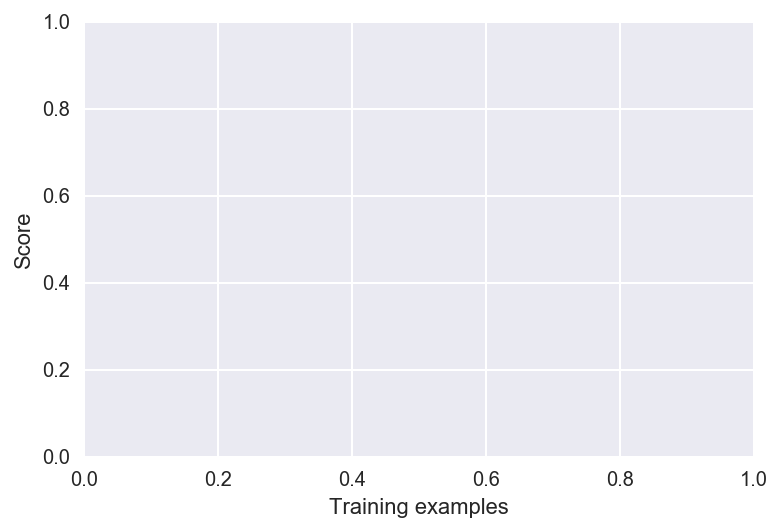

In [11]:
clf = grid.best_estimator_

y_pred = clf.predict_proba(X_train)
print('Train score: {:>10.5f}'.format(-log_loss(y_train, y_pred)))

y_pred = clf.predict_proba(X_test)
print('Test score : {:>10.5f}'.format(-log_loss(y_test, y_pred)))

cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=SEED)
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    plot_learning_curve(clf,
                        X_train, y_train,
                        cv=cv, scoring=scoring,
                        n_jobs=2)

In [ ]:
# clf = grid.best_estimator_

# param_name = 'C'
# param_range = [0.1, 0.2, 0.3, 0.4, 0.6, 0.8]

# cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=SEED)
# with warnings.catch_warnings():
#     warnings.simplefilter('ignore')
#     plot_validation_curve(clf, X_train, y_train, param_name, param_range,
#                           cv=cv, scoring=scoring, n_jobs=-1)

##### Algorithm: `KNeighborsClassifier`

In [66]:
from sklearn.decomposition import RandomizedPCA

N_COMP = 6

pca = PCA(random_state=SEED).fit(X_train)
X_train_pca = rpca.transform(X_train)[:, :N_COMP]
X_test_pca  = rpca.transform(X_test)[:, :N_COMP]

parameters = dict(
    n_neighbors=[100, 200, 300],
)
clf = KNeighborsClassifier(n_jobs=-1)
grid = GridSearchCV(clf, parameters, n_jobs=-1, scoring=scoring,
                    error_score=np.nan)

# Errors in calculating logloss should be ignored
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    %timeit -r1 -n1 grid.fit(X_train_pca, y_train)

print()
print(best_grid_results(grid))

NameError: name 'X_train' is not defined

<Container object of 21 artists>

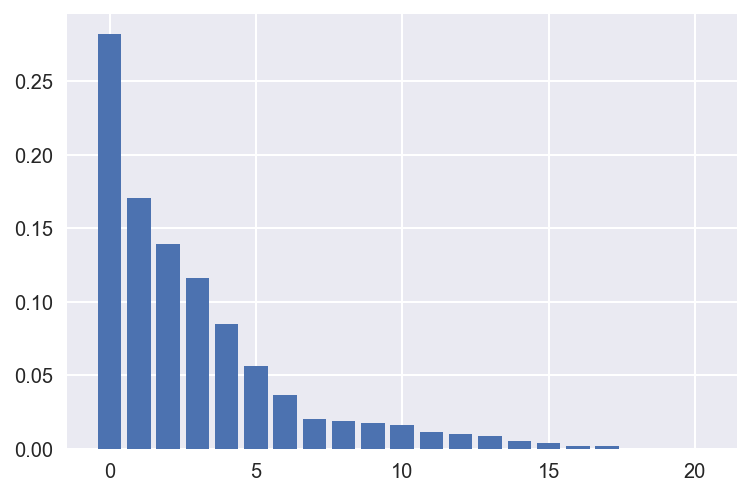

In [35]:
pca = PCA(random_state=SEED).fit(X_train)
comps = pca.explained_variance_ratio_
plt.bar(range(len(comps)), comps)

In [34]:
clf = grid.best_estimator_

y_pred = clf.predict_proba(X_train_pca)
print('Train score: {:>10.5f}'.format(-log_loss(y_train, y_pred)))

y_pred = clf.predict_proba(X_test_pca)
print('Test score : {:>10.5f}'.format(-log_loss(y_test, y_pred)))

Train score:   -0.70514
Test score :   -0.71849


##### Algorithm: `GradientBoostingClassifier`

In [9]:
df = read_rental_interest(TRAIN_FP)

n_posts = df.manager_id.value_counts().rename('n_posts')
df = df.merge(n_posts.to_frame(), left_on='manager_id', right_index=True)

df['n_photos']    = df.photos.map(lambda x: len(x))
df['n_feats']     = df.features.apply(lambda x: len(x))
df['len_descr']   = df.description.apply(lambda x: len(x))

# cateogrical
df['day_name'] = df.created.dt.weekday_name

features = [
    'price', 'n_posts', 'n_photos',
    'n_feats', 'len_descr', 'bedrooms', 'bathrooms', 
    'latitude', 'longitude', 'day_name'
]

X = df.loc[:, features]
X = pd.get_dummies(X, columns=['day_name'])

y = df.interest_level


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=.5, random_state=SEED, stratify=y)

NameError: name 'as_is' is not defined

In [19]:
parameters = dict(
    min_samples_split=[2, 6],
    max_depth=[3, 4],
)

clf = GradientBoostingClassifier(random_state=SEED)
grid = GridSearchCV(clf, parameters, n_jobs=-1, scoring=scoring)
%timeit -r1 -n1 grid.fit(X_train, y_train)

print()
print(best_grid_results(grid))

33.8 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)

Best score: -0.62637

*** For parameters: ***
max_depth: 4
min_samples_split: 2



Train score:    0.57795

Test score :    0.62404

46.1 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


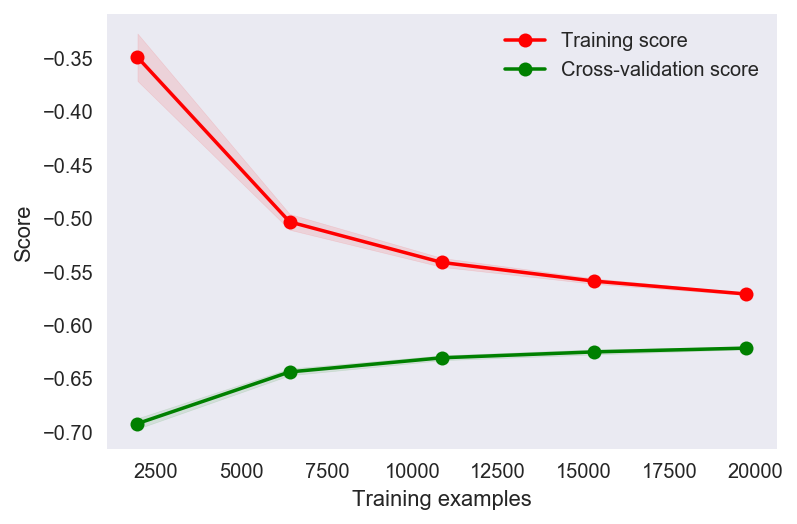

In [23]:
clf = grid.best_estimator_

y_pred = clf.predict_proba(X_train)
print('Train score: {:>10.5f}'.format(log_loss(y_train, y_pred)))

y_pred = clf.predict_proba(X_test)
print('Test score : {:>10.5f}'.format(log_loss(y_test, y_pred)))
print()

cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=SEED)
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    # so timeit works
    kwargs = dict(estimator=clf, X=X_train, y=y_train,
                  cv=cv, scoring=scoring, n_jobs=-1)
    %timeit -r1 -n1 plot_learning_curve(**kwargs)

In [ ]:
clf = grid.best_estimator_

cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=SEED)
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    kwargs = dict(estimator=clf, X=X_train, y=y_train,
                  param_name='max_depth', param_range = [2, 3, 4, 5, 6],
                  cv=cv, scoring=scoring, n_jobs=-1)
    %timeit -r1 -n1 plot_validation_curve(**kwargs)

##### Algorithm: `XGBoost`

- For trees, no scaling or booleans necessary

In [220]:
df = read_rental_interest(TRAIN_FP)

n_posts = df.manager_id.value_counts().rename('n_posts')
df = df.merge(n_posts.to_frame(), left_on='manager_id', right_index=True)


df['n_photos']    = df.photos.map(lambda x: len(x))
df['n_feats']     = df.features.apply(lambda x: len(x))

df.description = df.description.str.strip()
df['len_descr']   = df.description.apply(lambda x: len(x))

# cateogrical
df['day_name'] = df.created.dt.weekday_name

# bed/bath missing
def impute_bedbath(df, imp_val=-999):
    
    df = df.copy()
    no_bed = df.bedrooms == 0
    no_bath = df.bathrooms == 0
    all_missing = no_bath & no_bed
    
    df.loc[all_missing | no_bath, ['bedrooms', 'bathrooms']] = imp_val
    
    return df

def impute_coords(df, imp_val=-999):
    df = df.copy()
    df.loc[is_outlier_geo(df.latitude, df.longitude), ['latitude', 'longitude']] = imp_val
    return df

df = impute_bedbath(df)
df = impute_coords(df)

features = [
    'price', 'n_posts', 'n_photos',
    'n_feats', 'len_descr', 'bedrooms', 'bathrooms', 
    'latitude', 'longitude', 'day_name', 
]

X = df.loc[:, features]
X = pd.get_dummies(X, columns=['day_name'])

y = df.interest_level


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=.5, random_state=SEED, stratify=y)



- bools not necessary with tree, covered with variable that they are derived from
- man_avg and man_exp used (not just man_exp)
- No standardization or scaling necessary

WHY ARE SOME FEATURES DROPPED? (like bools and avg/exp, detailed explanation)
- Leaves out less important one?

In [19]:
import xgboost as xgb
parameters = dict(
    max_depth=[3, 4, 5, 6],
)

clf = xgb.XGBClassifier(objective='multi:softprob', silent=0,
                        nthread=1, seed=SEED, missing=-999)
grid = GridSearchCV(clf, parameters, n_jobs=3, scoring=scoring)
%timeit -r1 -n1 grid.fit(X_train, y_train)

print()
print(best_grid_results(grid))

25.1 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)

Best score: -0.61804

*** For parameters: ***
max_depth: 6


In [14]:
clf.fit(X_train, y_train)
# xgb.plot_tree(clf.booster())

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=-999, n_estimators=100, nthread=2,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=42, silent=0, subsample=1)

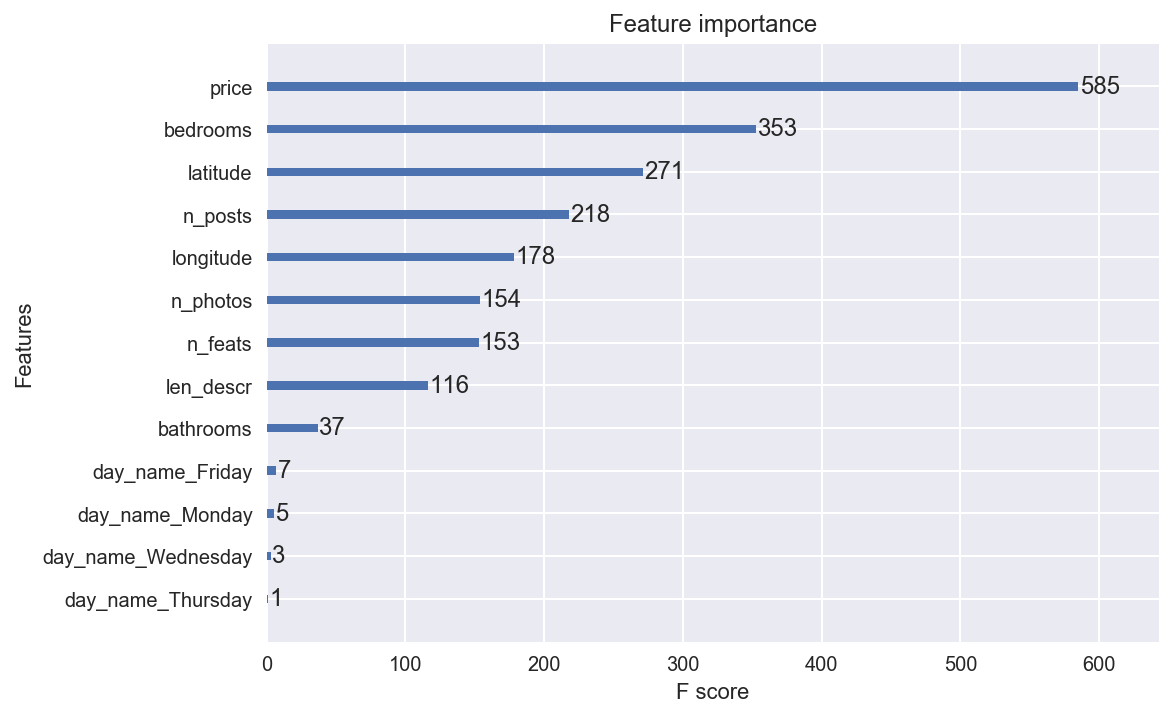

In [204]:
sns.set()
feat_imp = pd.Series(clf.booster().get_fscore()).sort_values(ascending=False)
xgb.plot_importance(clf.booster())

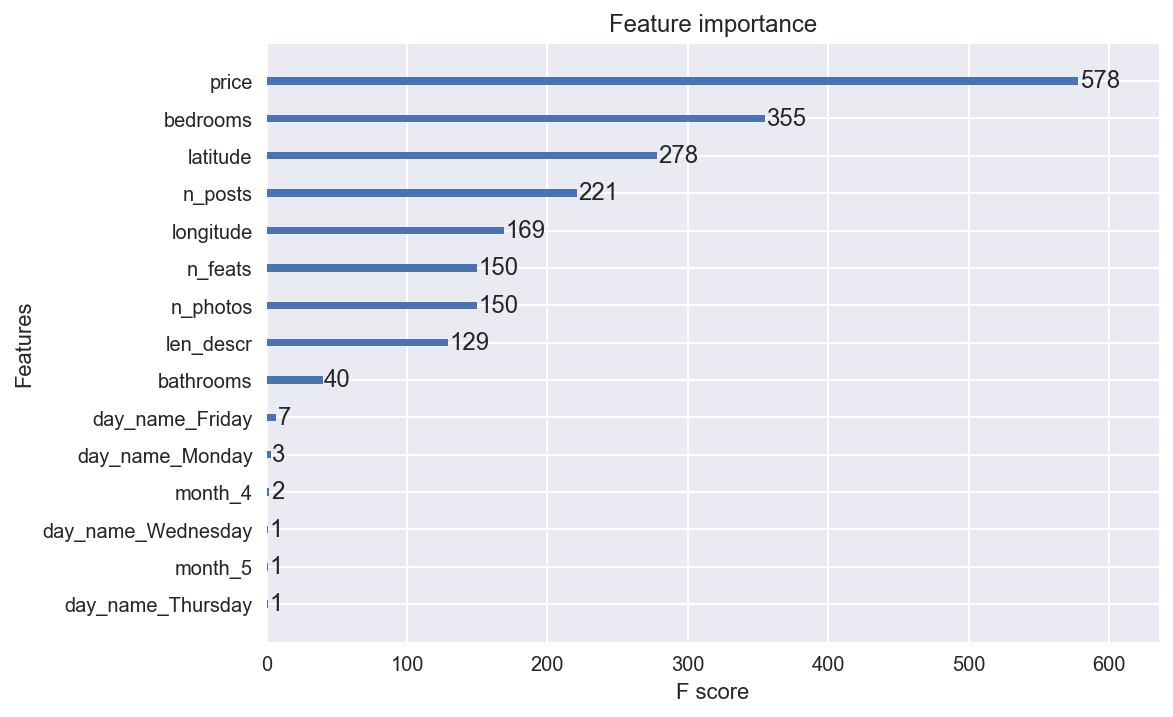

In [267]:
feat_imp = pd.Series(clf.booster().get_fscore()).sort_values(ascending=False)
xgb.plot_importance(clf.booster())

[autoreload of eda_plots failed: Traceback (most recent call last):
  File "/Users/mdlynch37/anaconda3/envs/py3/lib/python3.5/site-packages/IPython/extensions/autoreload.py", line 246, in check
    superreload(m, reload, self.old_objects)
  File "/Users/mdlynch37/anaconda3/envs/py3/lib/python3.5/site-packages/IPython/extensions/autoreload.py", line 369, in superreload
    module = reload(module)
  File "/Users/mdlynch37/anaconda3/envs/py3/lib/python3.5/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/Users/mdlynch37/anaconda3/envs/py3/lib/python3.5/importlib/__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 626, in _exec
  File "<frozen importlib._bootstrap_external>", line 674, in exec_module
  File "<frozen importlib._bootstrap_external>", line 780, in get_code
  File "<frozen importlib._bootstrap_external>", line 740, in source_to_code
  File "<frozen importlib._bootstrap>", line 222, in _call_w

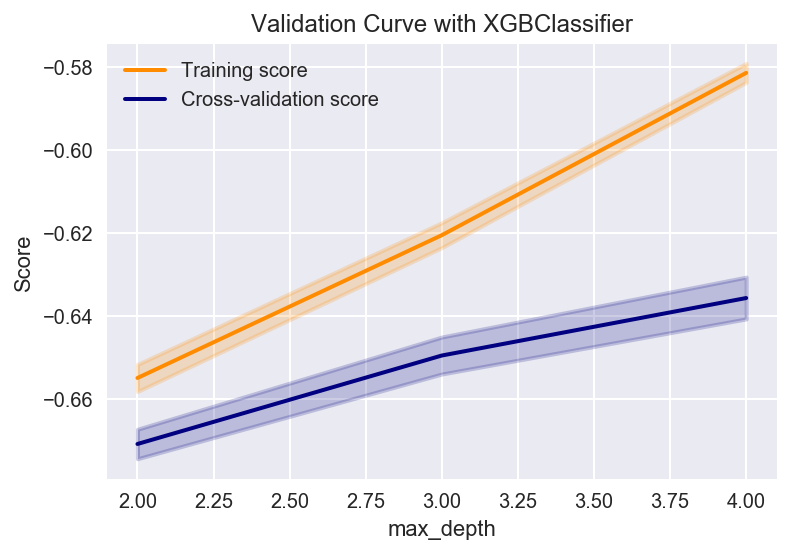

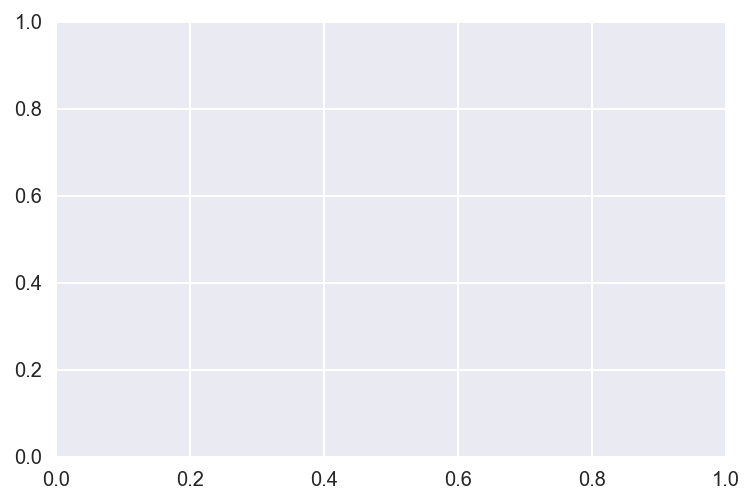

In [15]:
estimator = xgb.XGBClassifier(objective='multi:softprob', silent=0, seed=SEED)
plot_validation_curve(estimator, X_train, y_train,
                      'max_depth', [2, 3, 4], cv=2, scoring=scoring)

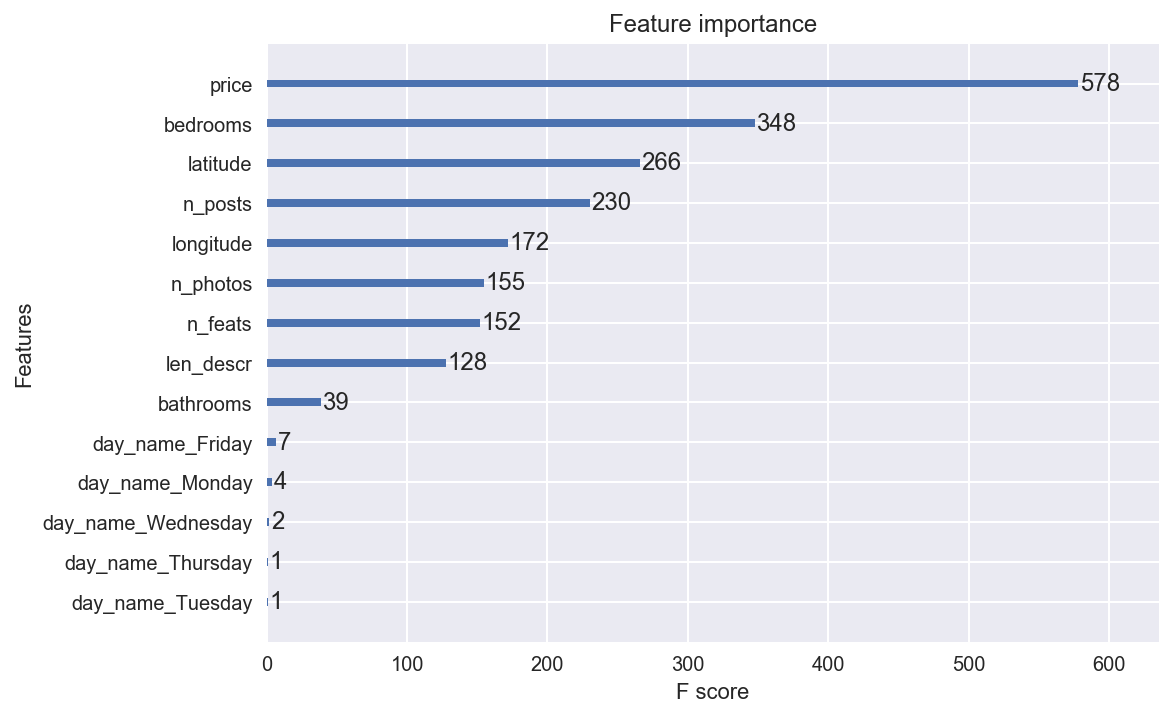

In [271]:
feat_imp = pd.Series(clf.booster().get_fscore()).sort_values(ascending=False)
xgb.plot_importance(clf.booster())

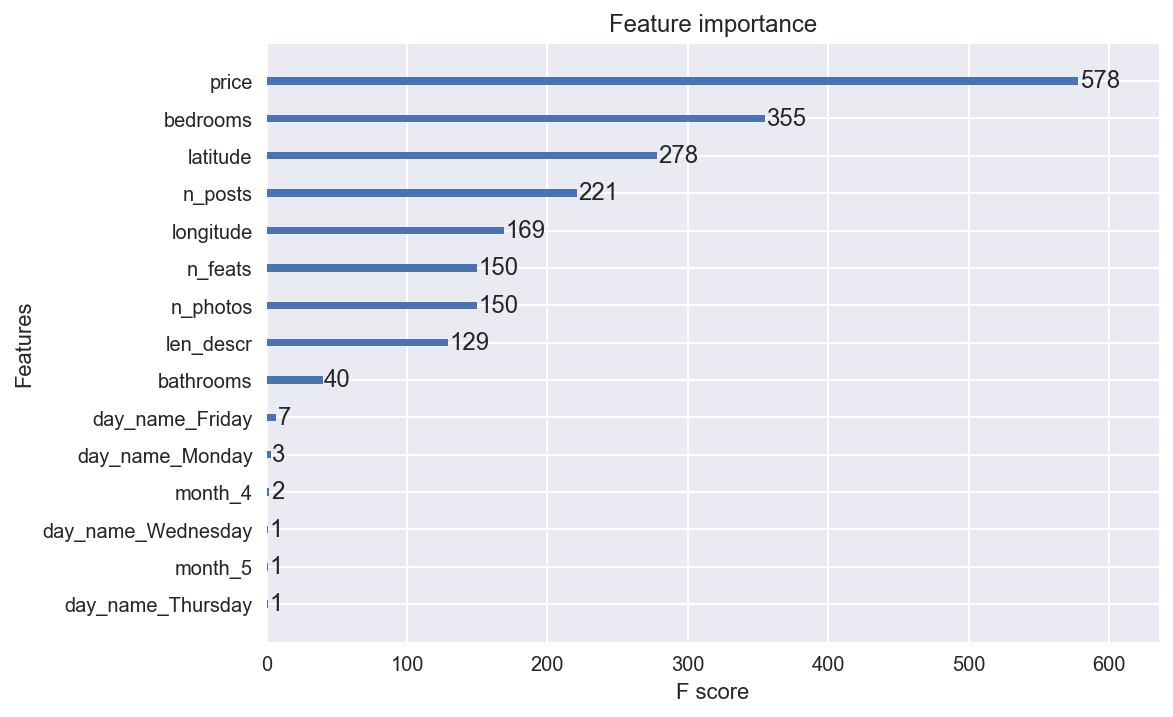

In [267]:
feat_imp = pd.Series(clf.booster().get_fscore()).sort_values(ascending=False)
xgb.plot_importance(clf.booster())

- Not easy to plot learning or vaidation curve because kernel needs to be restarted after `GridSearch` on `xgboost`. Need to use native cross-validation functions.

In [ ]:
# y_pred = clf.predict_proba(X_train)
# print('Train score: {:>10.5f}'.format(log_loss(y_train, y_pred)))

# y_pred = clf.predict_proba(X_test)
# print('Test score : {:>10.5f}'.format(log_loss(y_test, y_pred)))

# cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=SEED)
# with warnings.catch_warnings():
#     warnings.simplefilter('ignore')
#     plot_learning_curve(clf,
#                         X_train, y_train,
#                         cv=cv, scoring=scoring,
#                         n_jobs=-1)

In [ ]:
# clf = grid.best_estimator_
# clf = xgb.XGBClassifier(objective='multi:softprob', seed=SEED)

# param_name = 'max_depth'
# param_range = [2, 3, 4, 5, 6]

# cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=SEED)
# with warnings.catch_warnings():
#     warnings.simplefilter('ignore')
#     plot_validation_curve(clf, X_train, y_train, param_name, param_range,
#                           cv=cv, scoring=scoring, n_jobs=-1)

## `XGBoost`

In [17]:
import xgboost as xgb

/Users/mdlynch37/anaconda3/envs/py3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [27]:
dtrain = xgb.DMatrix(X_train, y_train, feature_names=X_train.columns)
dtest  = xgb.DMatrix(X_test, y_test, feature_names=X_test.columns)

evals  = [(dtest, 'eval'), (dtrain, 'train')]
evals_result = dict()

params = dict(
    max_depth=6,
    objective='multi:softmax',
    eval_metric='mlogloss',
    num_class=4,
    silent=0, 
)


bst = xgb.train(params, dtrain, num_boost_round=10, evals=evals,
                evals_result=evals_result
)

[0]	eval-mlogloss:1.13509	train-mlogloss:1.13017
[1]	eval-mlogloss:0.992171	train-mlogloss:0.982481
[2]	eval-mlogloss:0.898627	train-mlogloss:0.884873
[3]	eval-mlogloss:0.834232	train-mlogloss:0.816805
[4]	eval-mlogloss:0.790169	train-mlogloss:0.769531
[5]	eval-mlogloss:0.756866	train-mlogloss:0.73304
[6]	eval-mlogloss:0.73144	train-mlogloss:0.705025
[7]	eval-mlogloss:0.711759	train-mlogloss:0.683253
[8]	eval-mlogloss:0.696296	train-mlogloss:0.66434
[9]	eval-mlogloss:0.685253	train-mlogloss:0.650573


In [26]:
params = dict(
    max_depth=6,
    objective='multi:softmax',
    eval_metric='mlogloss',
    num_class=4,
    silent=0, 
)

xgb.cv(params, dtrain, num_boost_round=10, nfold=5, stratified=True,
       metrics=('mlogloss', 'merror'), seed=SEED)

,test-merror-mean,test-merror-std,test-mlogloss-mean,test-mlogloss-std,train-merror-mean,train-merror-std,train-mlogloss-mean,train-mlogloss-std
0,0.29470,0.00183,1.13554,0.00067,0.28275,0.00111,1.12910,0.00094
1,0.29174,0.00030,0.99237,0.00075,0.28042,0.00135,0.98156,0.00083
2,0.29044,0.00151,0.90003,0.00135,0.27874,0.00143,0.88457,0.00118
3,0.28971,0.00071,0.83550,0.00092,0.27734,0.00092,0.81573,0.00127
4,0.29016,0.00146,0.79071,0.00134,0.27597,0.00053,0.76732,0.00138
5,0.29024,0.00113,0.75767,0.00145,0.27521,0.00059,0.73106,0.00162
6,0.28935,0.00097,0.73248,0.00166,0.27332,0.00145,0.70279,0.00167
7,0.28903,0.00134,0.71292,0.00181,0.27123,0.00197,0.68013,0.00129
8,0.28850,0.00105,0.69822,0.00243,0.26934,0.00155,0.66209,0.00145
9,0.28724,0.00133,0.68604,0.00304,0.26707,0.00086,0.64665,0.00104


## Feature Engineering

In [ ]:
BASIC_FEATURES = ['bathrooms', 'bedrooms', 'price']
TARGET =  ['interest_level']


df = read_rental_interest(TRAIN_FP)
df_ = df[BASIC_FEATURES+TARGET]

X = df.drop('interest_level', axis=1)

X_train, X_test, y_train, y_test = (
    train_test_split(
        X, y, test_size=.2, stratify=y)
    )

X_train.shape

In [ ]:
np.bincount(y)

### Feature lists

#### Explore

In [ ]:
n_feats = df.features.map(lambda x: len(x))
plt.hist(n_feats, cumulative=True, normed=True, bins=300, align='left')
plt.title('CDF of number of features for each listing.')
print('min: {} (n={})\nmed: {}\nmax: {}'.format(
    n_feats.min(), (n_feats==0).sum(),
    n_feats.median(), n_feats.max()))
# n_feats.value_counts(normalize=True).sort_index()

In [ ]:
def contains_punc(criteria, feats_list, regex=False):
    """Checks for punctuation in feature list.
    
    Can be used to determine the nature of difference
    puncuations.
    
    Parameters
    ----------
    criteria : list of str or raw/str
        list of punctuation marks, or regex to match punctuation
    feats_list : list
    
    Returns
    -------
    has_punc : bool
    """
    
    if regex:
        reg = re.compile(criteria)
    
    # return True 
    for feat in feats_list:
        if regex:
            if reg.match(feat):
                return True
        else:
            for s in criteria:
                if s in feat:
                    return True
    
    # if no punctuation found in list of features
    return False

In [ ]:
from collections import Counter
import re

def extract_clean_feats(feats):
    """Extract and normalize each feature in list."""
    
#     cleaner = lambda x: re.sub(r'[ ]*[^\w ][ ]*', ' ', x)
    cleaner = lambda x: x.upper().strip().replace('-', '')
#     cleaner = lambda x: x
    cleaned = (cleaner(feat) for feat in feats)
    
    return cleaned


def count_feats(feat_col):
    """Extracts features from list and returns counter."""
    
    cnt = Counter()
    for _, feats in feat_col.iteritems():
        feats = set(extract_clean_feats(feats))  # remove dupes too
        cnt.update(feats)
        
    return cnt

feat_cnts = count_feats(df.features)
feat_cnts.most_common(5)

In [ ]:
df[df.features.map(lambda x: contains_punc(['*'], x))].head(2)

#### Include feature lists in model

In [ ]:
def binarize_from_list_vals(col):
    """Transforms Series of lists to dummy variables."""
    
    SEP = '~~//'  # any value that won't be in strings in list

    cleaned = col.apply(lambda x: extract_clean_feats(x))
    dummies = cleaned.str.join(sep=SEP).str.get_dummies(sep=SEP)

    return dummies


In [ ]:
# Testing against feature counter
# Discrepency caused by duplicate feats within a list
# Fix this with set() call in count_feats

if 1==0:
    feats_df = binarize_from_list_vals(df.features)

    results = []

    for i, (feat, cnt) in enumerate(feat_cnts.items()):
        try:
            cnt_dumm = feats_df[feat].sum()
            if cnt != cnt_dumm:
    #             print("Mismatch...\ndummies: {}\ncounter: {}\n'{}'\n"
    #                   .format(cnt_dumm, cnt, feat))
                results.append(dict(feat=feat, cnt_dumm=cnt_dumm, cnt=cnt))   
        except KeyError:
            results.append("Missing from dummies:\n'{}'\n".format(feat))
    #         break  # since it is not included in results list of dicts

    assert not results  # no discrepencies!

In [ ]:
from sklearn.decomposition import PCA
pca = PCA()

feats_train = feats_df.loc[X_train.index]
feats_test = feats_df.loc[X_test.index]

pca.fit(feats_train)

In [ ]:
list(pca.explained_variance_ratio_[:4])

In [ ]:
plt.title('Cumulative Explained Variance for PCA')

plt.plot(np.cumsum(pca.explained_variance_ratio_))

plt.xlim(0, 150)
plt.xlabel('components')
plt.ylabel('cumulative explained variance');

In [ ]:
N_COMPONENTS = 1000
# N_COMPONENTS = len(pca.components_)

cols = ['FeatComp{}'.format(i+1) for i in range(0, N_COMPONENTS)]

reduced_train = pd.DataFrame(
    pca.transform(feats_train)[:, :N_COMPONENTS], 
    columns=cols, index=feats_train.index
)
reduced_test  = pd.DataFrame(
    pca.transform(feats_test)[:, :N_COMPONENTS], 
    columns=cols, index=feats_test.index
)

# allows rejoining reduced data after reprocessing
X_train = X_train.loc[:, ~X_train.columns.isin(cols)]
X_test  = X_test.loc[:, ~X_test.columns.isin(cols)]

X_train = X_train.join(reduced_train)
X_test  = X_test.join(reduced_test)

In [ ]:
N = len(feats_train)

In [ ]:
steps = [('reducer', PCA()),
         ('clf', GradientBoostingClassifier(min_samples_split=50))]
pipe = Pipeline(steps=steps)

params = {
    'reducer': [PCA(), TruncatedSVD()],
    'reducer__n_components': [200, 300, 400],
#     'clf__min_samples_split': [120],
#     'clf__learning_rate': np.linspace(0.1, 0.4, 5),
#     'clf__learning_rate': [0.05, 0.1, 0.15],
#     'clf_max_depth': range(3, 7, 1),
#     'pca__n_components': [10, 20, 25],
#     'pca__n_components': [10, 40],
#     'clf__min_samples_split': [120, 180],
              }

grid = GridSearchCV(pipe, params, scoring=scoring, n_jobs=-1)
grid.fit(feats_train.iloc[:N], y_train[:N])
grid.best_score_

In [ ]:
gx = GridSearchExplorer(grid)
gx.plot(x='reducer__n_components', hue='reducer')

#### Combine with BASIC

In [ ]:
from sklearn.base import TransformerMixin

class DateEncoder(TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        dt = X.dt
        return pd.concat([dt.year, dt.month, dt.day], axis=1)
dates_df = pd.DataFrame(
    {'dates': pd.date_range('2015-10-30', '2015-11-02')})
mapper_dates = DataFrameMapper([
    ('dates', DateEncoder())
], input_df=True)
mapper_dates.fit_transform(dates_df)


In [ ]:
from sklearn_pandas import DataFrameMapper

class LogTransformer(TransformerMixin):
    
    def fit(self, X):
        return self
    
    def transform(self, X):
        return np.log(X)
    
dm = DataFrameMapper([
    (['bedrooms', 'bathrooms'], MinMaxScaler()),
    (['price'], [LogTransformer(), MinMaxScaler()])
])

dm.fit_transform(df)

In [ ]:
FEATURES = ['bathrooms', 'bedrooms', 'price', 'features']
TARGET =  ['interest_level']


df = read_rental_interest(TRAIN_FP, frac=.)
df_ = df[FEATURES+TARGET]


feats_bow = binarize_from_list_vals(df.features)

In [ ]:
X = df.drop(['interest_level', 'features'], axis=1).values
X = np.hstack((X, feats_bow))

X_train, X_test, y_train, y_test = (
    train_test_split(
        X, y, test_size=.2, stratify=y)
    )


X_train.shape

In [ ]:
from sklearn.svm import SVC


class FeatureSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, slice_):
        self.slice_ = slice_

    def fit(self, x, y=None):
        return self

    def transform(self, x, y=None):
        return x[:, self.slice_]


pipe = Pipeline([
    ('union', FeatureUnion([
        ('feature_list', Pipeline([
            ('selector', FeatureSelector(slice(3, None))),
            ('reducer', TruncatedSVD(n_components=100))
        ])),
        ('selector', FeatureSelector(slice(None, 3)))
    ])
    ),
    ('clf', GradientBoostingClassifier())
])

pipe.fit(X_train, y_train)

param_grid = {
#     'union__feature_list__reducer': [TruncatedSVD(), PCA()],
#     'union__feature_list__reducer__n_components': [100, 200],
    'clf__n_estimators': [100, 200, 500],
    'clf__min_samples_split': [2, 10, 50],
    'clf__learning_rate':[0.05, 0.1, .15]
#       'clf': [GradientBoostingClassifier(), SVC(probability=True),
#               RandomForestClassifier()]
}

grid = GridSearchCV(pipe, param_grid, scoring=scoring, n_jobs=-1)
grid.fit(X_train, y_train)
grid.best_score_

In [ ]:
grid.best_params_

In [ ]:
GridSearchExplorer(grid).plot(x='clf__n_estimators',
                              hue='clf__min_samples_split')

In [ ]:
from sklearn.svm import SVC


class FeatureSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, slice_):
        self.slice_ = slice_

    def fit(self, x, y=None):
        return self

    def transform(self, x, y=None):
        return x[:, self.slice_]


pipe = Pipeline([
    ('union', FeatureUnion([
        ('feature_list', Pipeline([
            ('selector', FeatureSelector(slice(3, None))),
            ('reducer', TruncatedSVD(n_components=100))
        ])),
        ('selector', FeatureSelector(slice(None, 3)))
    ])
    ),
    ('clf', GradientBoostingClassifier())
])

pipe.fit(X_train, y_train)

param_grid = {
#     'union__feature_list__reducer': [TruncatedSVD(), PCA()],
#     'union__feature_list__reducer__n_components': [100, 200],
    'clf__n_estimators': [100, 200, 500],
    'clf__min_samples_split': [2, 10, 50],
    'clf__learning_rate':[0.05, 0.1, .15]
#       'clf': [GradientBoostingClassifier(), SVC(probability=True),
#               RandomForestClassifier()]
}

grid = GridSearchCV(pipe, param_grid, scoring=scoring, n_jobs=-1)
grid.fit(X_train, y_train)
grid.best_score_

In [ ]:
gx = GridSearchExplorer(grid)
gx.plot(x='clf__learning_rate', hue='clf__n_estimators')

In [ ]:
# confusion matrix

### NLP with description feature:

In [ ]:
words = Counter()

def extract_words(feats):
    feats = [re.sub(r'[ ]*[^\w ][ ]*', ' ', s.upper())
             for s in feats]
    words = [word for s in feats for word in s.split()]
    
    return words

In [ ]:
for idx, feats in df.features.iteritems():
    words.update(extract_words(feats))

In [ ]:
words.most_common()

In [ ]:
df = read_rental_interest(TRAIN_FP)

In [ ]:
with open(TRAIN_FP) as f:
    x = f.read()
a = 10011000
x[a:a+540]

In [ ]:
s = 'itness gym, laundry facility & pet-friendly'

df[df.description.str.contains(s)].iat[0, 4]

- Strip:
    - leading spaces
    - html tags: `<br /><br />`
    - html entities?
    - returns: `\r`
    - weird separators
- Replace:
    - `w/ ` to `with`
    - `washer /dryer` and other unspaced slashes
    - `&` to `and`
- Separate words joined between sentences
    - e.g. `FloorsLimed Brick WallsPrivate BalconiesIntricate`
    - very important, lots of instances, spearate by caps
    - not possible when all caps
- Separate joined word without caps:
    - `Long Island Railroad isabout a 10 `

- New features:
    - Length of description
    - Has website (`website_redacted` or html tag)
    - Has email
    - Has phone number


In [ ]:
df.description.values[]
raise

In [ ]:
nlp = spacy.load('en')

### Other features

## Misc

### Train vs Test

In [128]:
df_test = read_rental_interest(TEST_FP)
df_train = read_rental_interest(TRAIN_FP).drop('interest_level', axis=1)

In [129]:
quant = df_train.select_dtypes([int, float]).columns.tolist()
qual = [col for col in df_train.columns if col in quant]

Quantitative

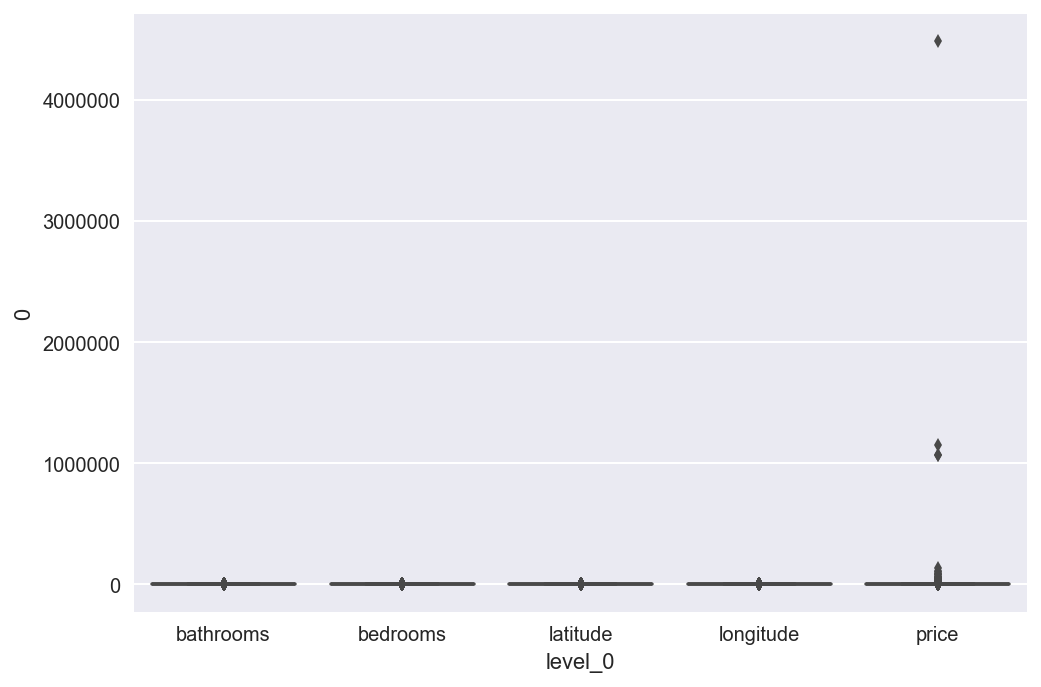

In [130]:
sns.boxplot(x='level_0', y='0', data=df_train[quant].unstack().rename('0').reset_index(level=0))

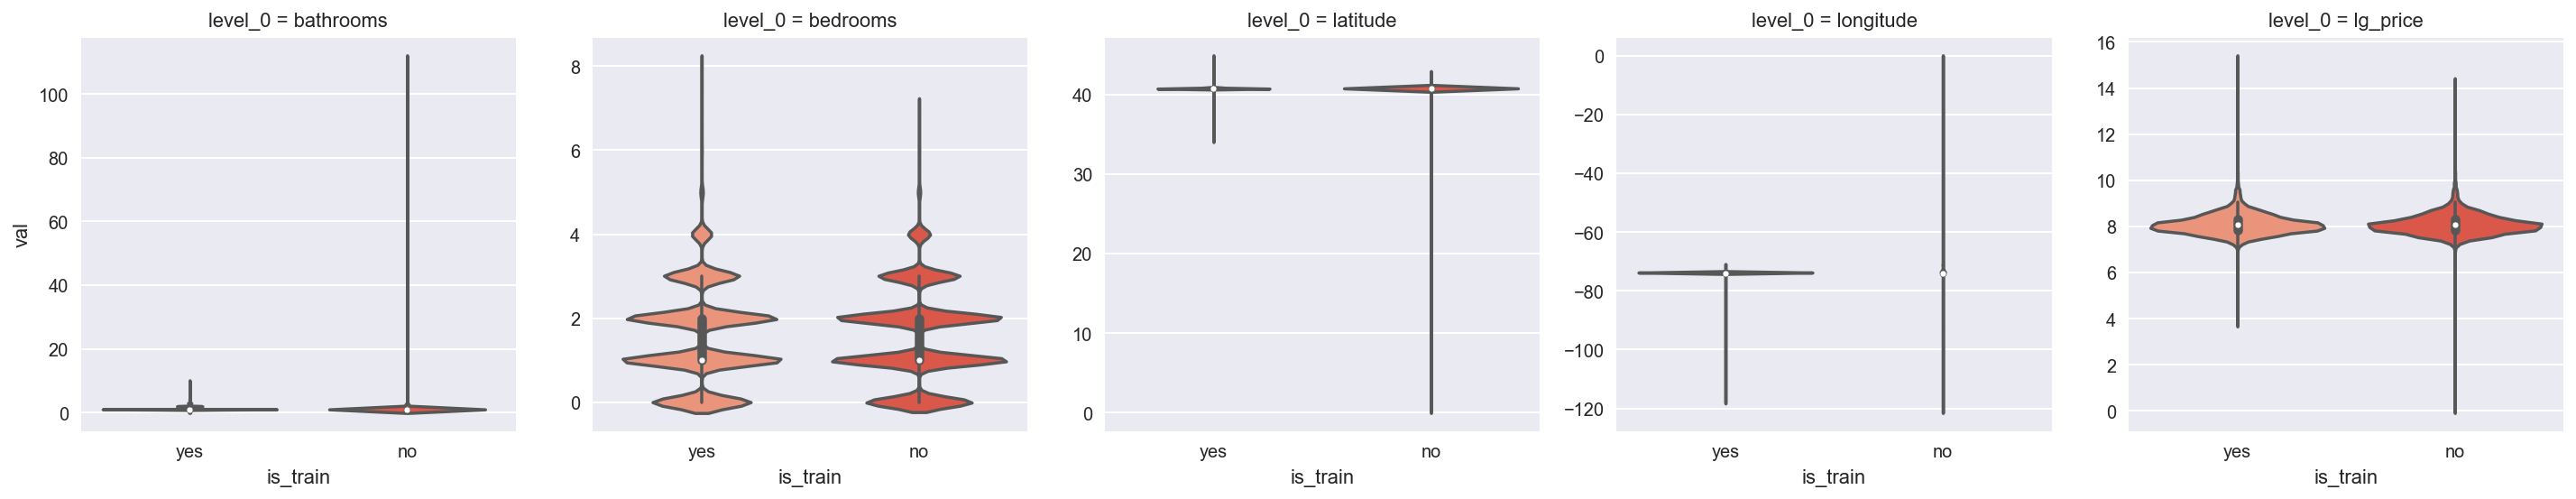

In [183]:
def basic_outl_drop(df):
    df = df.copy()
#     %%debug
#     import pdb; pdb.set_trace()
    df = df.loc[df.latitude!=0]
    df = df.loc[df.longitude!=0]
    df.price = np.log(df.price)
    df = df.rename(columns=dict(price='lg_price'))
    return df
    

data_tr_st = (df_train[quant].pipe(basic_outl_drop)
              .unstack()
              .rename('val')
              .reset_index(level=0)
)
data_te_st = (df_test[quant].pipe(basic_outl_drop)
              .unstack()
              .rename('val')
              .reset_index(level=0)
)
data = pd.concat([
    data_tr_st.assign(is_train='yes'),
    data_te_st.assign(is_train='no')
])
sns.factorplot(col='level_0', y='val', data=data, hue_order=['yes', 'no'],
               kind='violin', sharey=False, split=True, x='is_train')

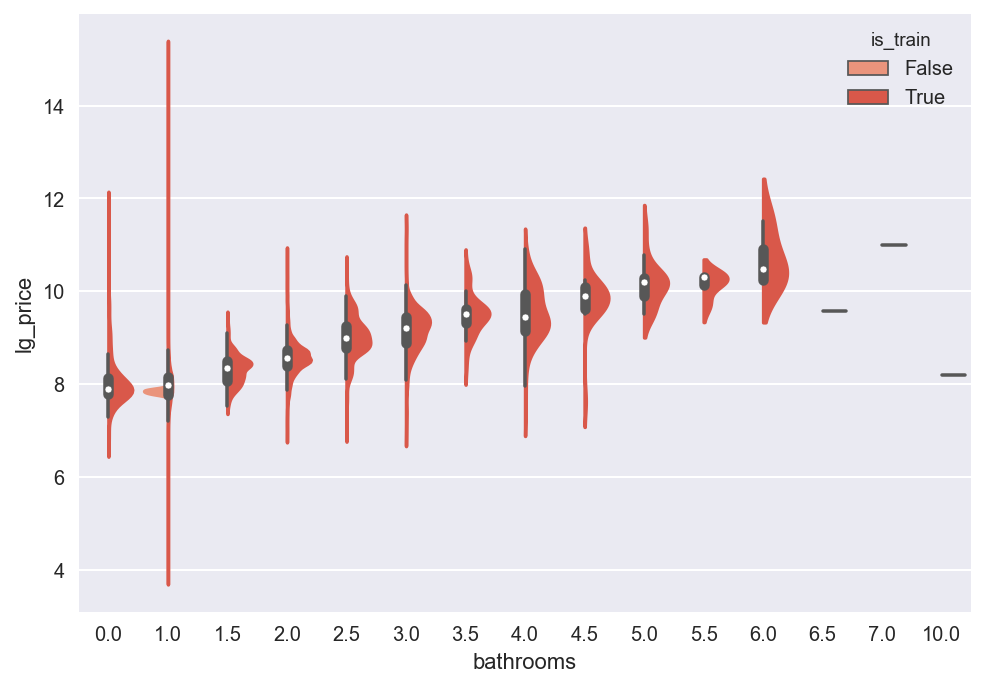

In [181]:
sns.violinplot(y='lg_price', 
               x='bathrooms',
               data=df_train.assign(is_train=df_train.latitude>40).pipe(basic_outl_drop),
               hue='is_train',
               split=True)

In [ ]:
def are_duplicated(df, normed=True):
    dupe_ns = []
    dupes = {}
    for name, ser in df.iteritems():
        print(name)
        print(type(ser))
        n = ser[ser.duplicated(keep=False)].sum()
        if type(n) is not int:
            %debug
        if normed:
            if type(n) is not int:
                print(n)
            n /= len(df)
        dupe_ns.append(n)
        dupes[name] = n
    
    return pd.DataFrame(dupes).T

are_duplicated(df)